In [2]:

import sys
sys.path
sys.path.insert(0, '/Users/asaadeldin/Downloads/GitHub/graspy')
import numpy as np
import math
from scipy.optimize import linear_sum_assignment
from scipy.optimize import minimize_scalar
from sklearn.utils import check_array
from sklearn.utils import column_or_1d

from graspy.match import SinkhornKnopp


class GraphMatch:
    """
    This class solves the Graph Matching Problem and the Quadratic Assignment Problem
    (QAP) through an implementation of the Fast Approximate QAP Algorithm (FAQ) (these
    two problems are the same up to a sign change) [1].

    This algorithm can be thought of as finding an alignment of the vertices of two 
    graphs which minimizes the number of induced edge disagreements, or, in the case
    of weighted graphs, the sum of squared differences of edge weight disagreements.
    The option to add seeds (known vertex correspondence between some nodes) is also
    available [2].


    Parameters
    ----------

    n_init : int, positive (default = 1)
        Number of random initializations of the starting permutation matrix that
        the FAQ algorithm will undergo. n_init automatically set to 1 if
        init_method = 'barycenter'

    init_method : string (default = 'barycenter')
        The initial position chosen

        "barycenter" : the non-informative “flat doubly stochastic matrix,”
        :math:`J=1*1^T /n` , i.e the barycenter of the feasible region

        "rand" : some random point near :math:`J, (J+K)/2`, where K is some random doubly
        stochastic matrix

    max_iter : int, positive (default = 30)
        Integer specifying the max number of Franke-Wolfe iterations.
        FAQ typically converges with modest number of iterations.

    shuffle_input : bool (default = True)
        Gives users the option to shuffle the nodes of A matrix to avoid results
        from inputs that were already matched.

    eps : float (default = 0.1)
        A positive, threshold stopping criteria such that FW continues to iterate
        while Frobenius norm of :math:`(P_{i}-P_{i+1}) > eps`

    gmp : bool (default = True)
        Gives users the option to solve QAP rather than the Graph Matching Problem
        (GMP). This is accomplished through trivial negation of the objective function.

    Attributes
    ----------

    perm_inds_ : array, size (n,) where n is the number of vertices in the fitted graphs.
        The indices of the optimal permutation (with the fixed seeds given) on the nodes of B,
        to best minimize the objective function :math:`f(P) = trace(A^T PBP^T )`.


    score_ : float
        The objective function value of for the optimal permutation found.


    References
    ----------
    .. [1] J.T. Vogelstein, J.M. Conroy, V. Lyzinski, L.J. Podrazik, S.G. Kratzer,
        E.T. Harley, D.E. Fishkind, R.J. Vogelstein, and C.E. Priebe, “Fast
        approximate quadratic programming for graph matching,” PLOS one, vol. 10,
        no. 4, p. e0121002, 2015.

    .. [2] D. Fishkind, S. Adali, H. Patsolic, L. Meng, D. Singh, V. Lyzinski, C. Priebe,
        Seeded graph matching, Pattern Recognit. 87 (2019) 203–215



    """

    def __init__(
        self,
        n_init=1,
        init_method="barycenter",
        max_iter=30,
        shuffle_input=True,
        eps=0.1,
        gmp=True,
    ):

        if type(n_init) is int and n_init > 0:
            self.n_init = n_init
        else:
            msg = '"n_init" must be a positive integer'
            raise TypeError(msg)
        if init_method == "rand":
            self.init_method = "rand"
        elif init_method == "barycenter":
            self.init_method = "barycenter"
            self.n_init = 1
        elif init_method == "convex":
            self.init_method = "convex"
            self.n_init = 1
        else:
            msg = 'Invalid "init_method" parameter string'
            raise ValueError(msg)
        if max_iter > 0 and type(max_iter) is int:
            self.max_iter = max_iter
        else:
            msg = '"max_iter" must be a positive integer'
            raise TypeError(msg)
        if type(shuffle_input) is bool:
            self.shuffle_input = shuffle_input
        else:
            msg = '"shuffle_input" must be a boolean'
            raise TypeError(msg)
        if eps > 0 and type(eps) is float:
            self.eps = eps
        else:
            msg = '"eps" must be a positive float'
            raise TypeError(msg)
        if type(gmp) is bool:
            self.gmp = gmp
        else:
            msg = '"gmp" must be a boolean'
            raise TypeError(msg)

    def fit(self, A, B, seeds_A=[], seeds_B=[]):
        """
        Fits the model with two assigned adjacency matrices

        Parameters
        ---------
        A : 2d-array, square, positive
            A square adjacency matrix

        B : 2d-array, square, positive
            A square adjacency matrix

        seeds_A : 1d-array, shape (m , 1) where m <= number of nodes (default = [])
            An array where each entry is an index of a node in `A`.

        seeds_B : 1d-array, shape (m , 1) where m <= number of nodes (default = [])
            An array where each entry is an index of a node in `B` The elements of
            `seeds_A` and `seeds_B` are vertices which are known to be matched, that is,
            `seeds_A[i]` is matched to vertex `seeds_B[i]`.

        Returns
        -------

        self : returns an instance of self
        """
        A = check_array(A, copy=True, ensure_2d=True)
        B = check_array(B, copy=True, ensure_2d=True)
        seeds_A = column_or_1d(seeds_A)
        seeds_B = column_or_1d(seeds_B)

        if A.shape[0] != B.shape[0]:
            msg = "Adjacency matrices must be of equal size"
            raise ValueError(msg)
        elif A.shape[0] != A.shape[1] or B.shape[0] != B.shape[1]:
            msg = "Adjacency matrix entries must be square"
            raise ValueError(msg)
        elif seeds_A.shape[0] != seeds_B.shape[0]:
            msg = "Seed arrays must be of equal size"
            raise ValueError(msg)
        elif seeds_A.shape[0] > A.shape[0]:
            msg = "There cannot be more seeds than there are nodes"
            raise ValueError(msg)
        elif not (seeds_A >= 0).all() or not (seeds_B >= 0).all():
            msg = "Seed array entries must be greater than or equal to zero"
            raise ValueError(msg)
        elif (
            not (seeds_A <= (A.shape[0] - 1)).all()
            or not (seeds_B <= (A.shape[0] - 1)).all()
        ):
            msg = "Seed array entries must be less than or equal to n-1"
            raise ValueError(msg)

        n = A.shape[0]  # number of vertices in graphs
        n_seeds = seeds_A.shape[0]  # number of seeds
        n_unseed = n - n_seeds

        score = math.inf
        perm_inds = np.zeros(n)

        obj_func_scalar = 1
        if self.gmp:
            obj_func_scalar = -1
            score = 0

        seeds_B_c = np.setdiff1d(range(n), seeds_B)
        if self.shuffle_input:
            seeds_B_c = np.random.permutation(seeds_B_c)
            # shuffle_input to avoid results from inputs that were already matched

        seeds_A_c = np.setdiff1d(range(n), seeds_A)
        permutation_A = np.concatenate([seeds_A, seeds_A_c], axis=None).astype(int)
        permutation_B = np.concatenate([seeds_B, seeds_B_c], axis=None).astype(int)
        A = A[np.ix_(permutation_A, permutation_A)]
        B = B[np.ix_(permutation_B, permutation_B)]

        # definitions according to Seeded Graph Matching [2].
        A11 = A[:n_seeds, :n_seeds]
        A12 = A[:n_seeds, n_seeds:]
        A21 = A[n_seeds:, :n_seeds]
        A22 = A[n_seeds:, n_seeds:]
        B11 = B[:n_seeds, :n_seeds]
        B12 = B[:n_seeds, n_seeds:]
        B21 = B[n_seeds:, :n_seeds]
        B22 = B[n_seeds:, n_seeds:]
        A11T = np.transpose(A11)
        A12T = np.transpose(A12)
        A22T = np.transpose(A22)
        B21T = np.transpose(B21)
        B22T = np.transpose(B22)

        for i in range(self.n_init):
            # setting initialization matrix
            if self.init_method == "rand":
                sk = SinkhornKnopp()
                K = np.random.rand(
                    n_unseed, n_unseed
                )  # generate a nxn matrix where each entry is a random integer [0,1]
                for i in range(10):  # perform 10 iterations of Sinkhorn balancing
                    K = sk.fit(K)
                J = np.ones((n_unseed, n_unseed)) / float(
                    n_unseed
                )  # initialize J, a doubly stochastic barycenter
                P = (K + J) / 2
            elif self.init_method == "barycenter":
                P = np.ones((n_unseed, n_unseed)) / float(n_unseed)
            elif self.init_method == "convex":
                P = self.convex_approx(A,B,seeds_A,seeds_B)
                #cols = [5,8,4,10,3,0,2,6,11,9,1,7]
                #P = np.zeros((n_unseed,n_unseed))
                #P[np.arange(n_unseed), cols] = 1

            const_sum = A21 @ np.transpose(B21) + np.transpose(A12) @ B12
            grad_P = math.inf  # gradient of P
            n_iter = 0  # number of FW iterations

            # OPTIMIZATION WHILE LOOP BEGINS
            while grad_P > self.eps and n_iter < self.max_iter:

                delta_f = (
                    const_sum + A22 @ P @ B22T + A22T @ P @ B22
                )  # computing the gradient of f(P) = -tr(APB^tP^t)
                rows, cols = linear_sum_assignment(
                    obj_func_scalar * delta_f
                )  # run hungarian algorithm on gradient(f(P))
                Q = np.zeros((n_unseed, n_unseed))
                Q[rows, cols] = 1  # initialize search direction matrix Q

                def f(x):  # computing the original optimization function
                    return obj_func_scalar * (
                        np.trace(A11T @ B11)
                        + np.trace(np.transpose(x * P + (1 - x) * Q) @ A21 @ B21T)
                        + np.trace(np.transpose(x * P + (1 - x) * Q) @ A12T @ B12)
                        + np.trace(
                            A22T
                            @ (x * P + (1 - x) * Q)
                            @ B22
                            @ np.transpose(x * P + (1 - x) * Q)
                        )
                    )

                alpha = minimize_scalar(
                    f, bounds=(0, 1), method="bounded"
                ).x  # computing the step size
                P_i1 = alpha * P + (1 - alpha) * Q  # Update P
                grad_P = np.linalg.norm(P - P_i1)
                P = P_i1
                n_iter += 1
            # end of FW optimization loop

            row, col = linear_sum_assignment(
                -P
            )  # Project onto the set of permutation matrices
            perm_inds_new = np.concatenate(
                (np.arange(n_seeds), np.array([x + n_seeds for x in col]))
            )

            score_new = np.trace(
                np.transpose(A) @ B[np.ix_(perm_inds_new, perm_inds_new)]
            )  # computing objective function value

            if obj_func_scalar * score_new < obj_func_scalar * score:  # minimizing
                score = score_new
                perm_inds = np.zeros(n, dtype=int)
                perm_inds[permutation_A] = permutation_B[perm_inds_new]

        permutation_A_unshuffle = _unshuffle(permutation_A, n)
        A = A[np.ix_(permutation_A_unshuffle, permutation_A_unshuffle)]
        permutation_B_unshuffle = _unshuffle(permutation_B, n)
        B = B[np.ix_(permutation_B_unshuffle, permutation_B_unshuffle)]
        score = np.trace(np.transpose(A) @ B[np.ix_(perm_inds, perm_inds)])

        self.perm_inds_ = perm_inds  # permutation indices
        self.score_ = score  # objective function value
        return self

    def fit_predict(self, A, B, seeds_A=[], seeds_B=[]):
        """
        Fits the model with two assigned adjacency matrices, returning optimal
        permutation indices

        Parameters
        ---------
        A : 2d-array, square, positive
            A square, positive adjacency matrix

        B : 2d-array, square, positive
            A square, positive adjacency matrix

        seeds_A : 1d-array, shape (m , 1) where m <= number of nodes (default = [])
            An array where each entry is an index of a node in `A`.

        seeds_B : 1d-array, shape (m , 1) where m <= number of nodes (default = [])
            An array where each entry is an index of a node in `B` The elements of
            `seeds_A` and `seeds_B` are vertices which are known to be matched, that is,
            `seeds_A[i]` is matched to vertex `seeds_B[i]`.

        Returns
        -------

        self : returns an instance of self
        """
        self.fit(A, B, seeds_A, seeds_B)
        return self.perm_inds_
    
    def convex_approx(self, A, B, seeds_A=[], seeds_B=[]):
        if not self.gmp:
            A=-A
        A = check_array(A, copy=True, ensure_2d=True)
        B = check_array(B, copy=True, ensure_2d=True)
        seeds_A = column_or_1d(seeds_A)
        seeds_B = column_or_1d(seeds_B)
        
        n = A.shape[0]  # number of vertices in graphs
        n_seeds = seeds_A.shape[0]  # number of seeds
        n_unseed = n - n_seeds

        obj_func_scalar = 1
        #if self.gmp:
            #obj_func_scalar = -1

        A12 = A[:n_seeds, n_seeds:]
        A21 = A[n_seeds:, :n_seeds]
        A22 = A[n_seeds:, n_seeds:]

        B12 = B[:n_seeds, n_seeds:]
        B21 = B[n_seeds:, :n_seeds]
        B22 = B[n_seeds:, n_seeds:]
        
        AtA = np.transpose(np.concatenate((A12,A22),axis=0)) @ np.concatenate((A12,A22),axis=0)
        BBt = np.concatenate((B21,B22),axis=1) @ np.transpose(np.concatenate((B21,B22),axis=1))

        AB21_12 = A21 @ np.transpose(B21) + np.transpose(A12) @ B12
        P = np.ones((n_unseed, n_unseed)) / float(n_unseed)
        
        grad_P = math.inf  # gradient of P
        n_iter = 0
            
        #while grad_P > self.eps and n_iter < self.max_iter:
        while n_iter<100:
            delta_f = (AtA @ P + P @ BBt - AB21_12 - np.transpose(A22) @ P @ B22 - A22 @ P @ B22) #if janky check this
            rows, cols = linear_sum_assignment(-obj_func_scalar * delta_f)

            Q = np.zeros((n_unseed, n_unseed))
            Q[rows, cols] = 1 

            C22 = (A22 @ (P-Q)) - ((P-Q) @ B22)
            D22 = (A22 @ Q) - (Q @ B22)

            if (n_seeds > 0):
                C21 = -(P-Q) @ B21
                C12 = A12 @ (P-Q)

                D21 = A21 - Q @ B21
                D12 = A12 @ Q - B12
            else:
                C21, C12, D21, D12 = 0,0,0,0

            aq = np.sum(np.multiply(C22,C22)) + np.sum(np.multiply(C21,C21)) + np.sum(np.multiply(C12,C12)) #if janky check this
            bq = np.sum(np.multiply(C22, D22)) + np.sum(np.multiply(C21, D21)) + np.sum(np.multiply(C12, D12))
            

            if aq == 0:
                alpha = 0
            else:
                alpha = -bq/aq

            P_i1 = alpha*P + (1-alpha)*Q
            f_new = np.sum(np.multiply(A22 @ P_i1 - P_i1 @ B22,A22 @ P_i1 - P_i1 @ B22))
            grad_P = np.linalg.norm(P - P_i1)
            P = P_i1
            n_iter += 1

        row, col = linear_sum_assignment(-P)
        P_f = np.zeros((n_unseed, n_unseed))
        P_f[rows, cols] = 1 
        return P


def _unshuffle(array, n):
    unshuffle = np.array(range(n))
    unshuffle[array] = np.array(range(n))
    return unshuffle



    
    
    

In [3]:
def _get_AB(qap_prob):
    with open("qapdata/" + qap_prob + ".dat") as f:
        f = [int(elem) for elem in f.read().split()]

        # adjusting
        f = np.array(f[1:])
        n = int(math.sqrt(len(f) / 2))
        f = f.reshape(2 * n, n)
        A = f[:n, :]
        B = f[n:, :]
        return A, B
    
bary = GraphMatch(gmp=False)
convex = GraphMatch(gmp=False, init_method="convex")

In [4]:
qapprob = ["chr12c","chr15a","chr15c","chr20b","chr22b","esc16b",
          "rou12","rou15","rou20","tai10a","tai15a","tai17a","tai20a",
          "tai30a","tai35a","tai40a"]
n_qap = len(qapprob)
convex_scores = np.zeros(n_qap)
bari_scores = np.zeros(n_qap)
den = 5
for i in range(n_qap):
    c_min = [0]*den
    b_min = [0]*den
    for k in range(den):
        A, B = _get_AB(qapprob[i])
        n = A.shape[0]
        score = convex.fit(A,B).score_
        c_min[k] = score

        score = bary.fit(A,B).score_
        b_min[k] = score
        
    convex_scores[i] = min(c_min)
    bari_scores[i] += min(b_min)

print(convex_scores)
print(bari_scores)
#print(P)

[1.366000e+04 1.032000e+04 2.073000e+04 3.134000e+03 7.554000e+03
 3.120000e+02 2.483220e+05 3.749680e+05 7.737580e+05 1.540580e+05
 4.169160e+05 5.202920e+05 7.257500e+05 1.869414e+06 2.487078e+06
 3.243936e+06]
[1.310000e+04 1.639800e+04 1.193600e+04 2.826000e+03 8.582000e+03
 3.080000e+02 2.451680e+05 3.714580e+05 7.438840e+05 1.579540e+05
 3.973760e+05 5.206960e+05 7.361400e+05 1.858536e+06 2.458852e+06
 3.225948e+06]


In [5]:
import pandas as pd
opt = [11156,9896,9504,2298,6194,292,235528,354210,725522,135028,388214,491812,703482,1818146,2422002,3139370]
mat = np.zeros((n_qap,3))
mat[:,0] = opt
mat[:,1] = bari_scores
mat[:,2] = convex_scores
mat = mat.astype(int)
df = pd.DataFrame(mat,columns=["OPT","Bary Init","Convex Init"])
df.insert(0,"QAP",qapprob,True)
print(df)

       QAP      OPT  Bary Init  Convex Init
0   chr12c    11156      13100        13660
1   chr15a     9896      16398        10320
2   chr15c     9504      11936        20730
3   chr20b     2298       2826         3134
4   chr22b     6194       8582         7554
5   esc16b      292        308          312
6    rou12   235528     245168       248322
7    rou15   354210     371458       374968
8    rou20   725522     743884       773758
9   tai10a   135028     157954       154058
10  tai15a   388214     397376       416916
11  tai17a   491812     520696       520292
12  tai20a   703482     736140       725750
13  tai30a  1818146    1858536      1869414
14  tai35a  2422002    2458852      2487078
15  tai40a  3139370    3225948      3243936


[False  True False  True  True  True  True False False False  True False
 False  True False]


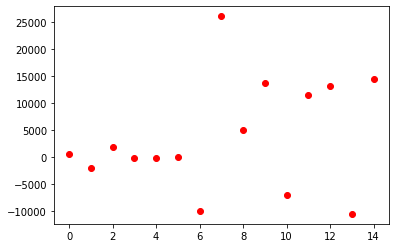

In [414]:
print(convex_scores < bari_scores)
import matplotlib.pyplot as plt
plt.plot(convex_scores-bari_scores,"ro")

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
from joblib import Parallel, delayed

sys.path
sys.path.insert(0, "/Users/asaadeldin/Downloads/GitHub/graspy")

from graspy.simulations import sample_edges_corr

def match_ratio(v, w):
    return 1 - (np.count_nonzero(abs(v - w)) / n_vert)

n_vert = 150
lambd = np.random.uniform(.1,.9, (n_vert,n_vert))
rho = 0.9
A,B = sample_edges_corr(lambd, rho*np.ones((n_vert,n_vert)))

node_shuffle_input = np.random.permutation(n_vert)
A_shuffle = A[np.ix_(node_shuffle_input, node_shuffle_input)]
node_unshuffle_input = np.array(range(n_vert))
node_unshuffle_input[node_shuffle_input] = np.array(range(n_vert))
convex = GraphMatch()
convex = convex.fit(A_shuffle,B)

print(match_ratio(convex.perm_inds_,node_shuffle_input))

0.00666666666666671


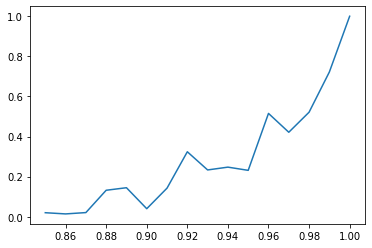

In [14]:
rhos = np.arange(0.85,1,.01)
n = rhos.shape[0]
lambd = np.random.uniform(.1,.9, (n_vert,n_vert))
ratios = np.zeros(n)
for i in range(n):
    s = 0
    for x in range(10):
        rho = rhos[i]
        A,B = sample_edges_corr(lambd, rho*np.ones((n_vert,n_vert)))
        node_shuffle_input = np.random.permutation(n_vert)
        A_shuffle = A[np.ix_(node_shuffle_input, node_shuffle_input)]
        convex = GraphMatch()
        convex = convex.fit(A_shuffle,B)
        s+= match_ratio(convex.perm_inds_,node_shuffle_input)
    ratios[i] = s/10
plt.plot(rhos,ratios)



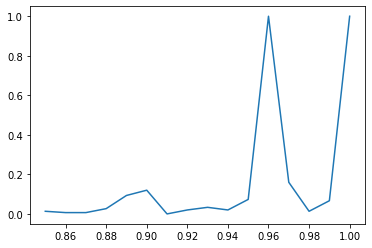

In [15]:
rhos = np.arange(0.85,1,.01)
n = rhos.shape[0]
lambd = np.random.uniform(.1,.9, (n_vert,n_vert))
ratios = np.zeros(n)
for i in range(n):
    s = 0
    for x in range(1):
        rho = rhos[i]
        A,B = sample_edges_corr(lambd, rho*np.ones((n_vert,n_vert)))
        node_shuffle_input = np.random.permutation(n_vert)
        A_shuffle = A[np.ix_(node_shuffle_input, node_shuffle_input)]
        convex = GraphMatch(init_method = "convex")
        convex = convex.fit(A_shuffle,B)
        s+= match_ratio(convex.perm_inds_,node_shuffle_input)
    ratios[i] = s/1
plt.plot(rhos,ratios)


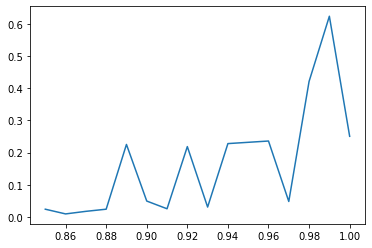

In [16]:
rhos = np.arange(0.85,1,.01)
n = rhos.shape[0]
lambd = np.random.uniform(.1,.9, (n_vert,n_vert))
ratios = np.zeros(n)
for i in range(n):
    s = 0
    for x in range(5):
        rho = rhos[i]
        A,B = sample_edges_corr(lambd, rho*np.ones((n_vert,n_vert)))
        node_shuffle_input = np.random.permutation(n_vert)
        A_shuffle = A[np.ix_(node_shuffle_input, node_shuffle_input)]
        convex = GraphMatch(init_method = "convex")
        convex = convex.fit(A_shuffle,B)
        s+= match_ratio(convex.perm_inds_,node_shuffle_input)
    ratios[i] = s/5
plt.plot(rhos,ratios)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
from joblib import Parallel, delayed

sys.path
sys.path.insert(0, "/Users/asaadeldin/Downloads/GitHub/graspy")

from graspy.simulations import sample_edges_corr

def match_ratio(v, w):
    return 1 - (np.count_nonzero(abs(v - w)) / n)

n_vert = 150
lambd = np.random.uniform(low=.1,high=.9)

n = 300
n_init = 2
n_rho = 17

rhos = np.linspace(0.6,1.0,num=n_rho)
ratios = np.zeros((n_rho, n_init))
n_per_block = 100
n_blocks = 3
block_members = np.array(n_blocks * [n_per_block])
block_probs = np.array([[0.7, 0.3, 0.4], [0.3, 0.7, 0.3], [0.4, 0.3, 0.7]])
directed = False
loops = False
n_realizations = 1
bary = GraphMatch()
convex = GraphMatch(init_method="convex")

np.random.seed(8888)
for k in range(n_rho):
    rho = rhos[k]
    outs = np.zeros((n_realizations,2))
    for i in range(n_realizations):
        A1, A2 = sbm_corr(
            block_members, block_probs, rho, directed=directed, loops=loops
        )

        node_shuffle_input = np.random.permutation(n)
        A2_shuffle = A2[np.ix_(node_shuffle_input, node_shuffle_input)]
        node_unshuffle_input = np.array(range(n))
        node_unshuffle_input[node_shuffle_input] = np.array(range(n))

        bari_ = bary.fit(A1,A2)
        convex_ = convex.fit(A1,A2)

        outs[i,:] = [match_ratio(bari_.perm_inds_, node_unshuffle_input), 
                            match_ratio(convex_.perm_inds_, node_unshuffle_input)]

    ratios[k, :] = np.sum(outs,axis=0) / n_realizations

for i in range(n_init):
    plt.plot(rhos, ratios[:, i], "-o", label=str(rhos[i]))



KeyboardInterrupt: 

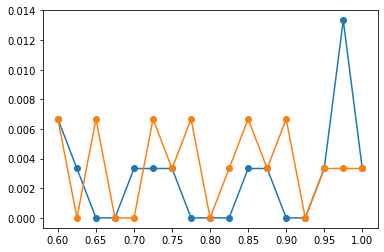

In [442]:
for i in range(n_init):
    plt.plot(rhos, ratios[:, i], "-o", label=str(rhos[i]))

In [335]:
A, B = _get_AB("chr15a")
n = A.shape[0]
chr12c = bary.fit(A, B)
score = chr12c.score_
print(score)

16398


In [ ]:
def convex_approx(A, B, seeds_A=[], seeds_B=[]):
        A = check_array(A, copy=True, ensure_2d=True)
        A = A
        B = check_array(B, copy=True, ensure_2d=True)
        seeds_A = column_or_1d(seeds_A)
        seeds_B = column_or_1d(seeds_B)
        
        n = A.shape[0]  # number of vertices in graphs
        n_seeds = seeds_A.shape[0]  # number of seeds
        n_unseed = n - n_seeds

        obj_func_scalar = 1
        if self.gmp:
            obj_func_scalar = -1

        A11 = A[:n_seeds, :n_seeds]
        A12 = A[:n_seeds, n_seeds:]
        A21 = A[n_seeds:, :n_seeds]
        A22 = A[n_seeds:, n_seeds:]
        B11 = B[:n_seeds, :n_seeds]
        B12 = B[:n_seeds, n_seeds:]
        B21 = B[n_seeds:, :n_seeds]
        B22 = B[n_seeds:, n_seeds:]
        A11T = np.transpose(A11)
        A12T = np.transpose(A12)
        A22T = np.transpose(A22)
        B21T = np.transpose(B21)
        B22T = np.transpose(B22)
        
        
            delta_f = (
                    const_sum + A22 @ P @ B22T + A22T @ P @ B22
                )  # computing the gradient of f(P) = -tr(APB^tP^t)
            
            def f(x):  # computing the original optimization function
                return obj_func_scalar * (
                    np.trace(A11T @ B11)
                    + np.trace(np.transpose(x * P + (1 - x) * Q) @ A21 @ B21T)
                    + np.trace(np.transpose(x * P + (1 - x) * Q) @ A12T @ B12)
                    + np.trace(
                        A22T
                        @ (x * P + (1 - x) * Q)
                        @ B22
                        @ np.transpose(x * P + (1 - x) * Q)
                    )
                )

            alpha = minimize_scalar(
                f, bounds=(0, 1), method="bounded"
            ).x  # computing the step size
            P_i1 = alpha * P + (1 - alpha) * Q  # Update P
            grad_P = np.linalg.norm(P - P_i1)
            P = P_i1
            n_iter += 1
            # end of FW optimization loop
        
        
        

In [370]:
def convex_approx(A, B, seeds_A=[], seeds_B=[]):
        A = check_array(A, copy=True, ensure_2d=True)
        A = A
        B = check_array(B, copy=True, ensure_2d=True)
        seeds_A = column_or_1d(seeds_A)
        seeds_B = column_or_1d(seeds_B)
        
        n = A.shape[0]  # number of vertices in graphs
        n_seeds = seeds_A.shape[0]  # number of seeds
        n_unseed = n - n_seeds

        obj_func_scalar = 1
        #if self.gmp:
            #obj_func_scalar = -1

        A12 = A[:n_seeds, n_seeds:]
        A21 = A[n_seeds:, :n_seeds]
        A22 = A[n_seeds:, n_seeds:]

        B12 = B[:n_seeds, n_seeds:]
        B21 = B[n_seeds:, :n_seeds]
        B22 = B[n_seeds:, n_seeds:]
        
        AtA = np.transpose(np.concatenate((A12,A22),axis=0)) @ np.concatenate((A12,A22),axis=0)
        BBt = np.concatenate((B21,B22),axis=1) @ np.transpose(np.concatenate((B21,B22),axis=1))

        AB21_12 = A21 @ np.transpose(B21) + np.transpose(A12) @ B12
        P = np.ones((n_unseed, n_unseed)) / float(n_unseed)
        
        grad_P = math.inf  # gradient of P
        n_iter = 0
            
        #while grad_P > self.eps and n_iter < self.max_iter:
        while n_iter<100:
            delta_f = (AtA @ P + P @ BBt - AB21_12 - np.transpose(A22) @ P @ B22 - A22 @ P @ B22) #if janky check this
            rows, cols = linear_sum_assignment(-obj_func_scalar * delta_f)

            Q = np.zeros((n_unseed, n_unseed))
            Q[rows, cols] = 1 

            C22 = (A22 @ (P-Q)) - ((P-Q) @ B22)
            D22 = (A22 @ Q) - (Q @ B22)

            if (n_seeds > 0):
                C21 = -(P-Q) @ B21
                C12 = A12 @ (P-Q)

                D21 = A21 - Q @ B21
                D12 = A12 @ Q - B12
            else:
                C21, C12, D21, D12 = 0,0,0,0

            aq = np.sum(np.multiply(C22,C22)) + np.sum(np.multiply(C21,C21)) + np.sum(np.multiply(C12,C12)) #if janky check this
            bq = np.sum(np.multiply(C22, D22)) + np.sum(np.multiply(C21, D21)) + np.sum(np.multiply(C12, D12))
            

            if aq == 0:
                alpha = 0
            else:
                alpha = -bq/aq

            P_i1 = alpha*P + (1-alpha)*Q
            f_new = np.sum(np.multiply(A22 @ P_i1 - P_i1 @ B22,A22 @ P_i1 - P_i1 @ B22))
            grad_P = np.linalg.norm(P - P_i1)
            P = P_i1
            n_iter += 1

        row, col = linear_sum_assignment(-P)
        P_f = np.zeros((n_unseed, n_unseed))
        P_f[rows, cols] = 1 
        return P


In [377]:
A, B = _get_AB("chr12c")
n = A.shape[0]
P = convex_approx(-A, B)
#P = np.ones((n, n)) / float(n)
score = np.trace(np.transpose(A)@P@B@np.transpose(P))
print(score)

36338.919762521116


In [260]:
def convex(A,B):
    n = A.shape[0]
    At = np.transpose(A)
    Bt = np.transpose(B)
    P = np.ones((n, n)) / float(n)
    n_iter = 0
    while n_iter < 100:
        grad = At@A@P + P@B@Bt - At@P@B - A@P@B
        rows, cols = linear_sum_assignment(
                -grad
            )  # run hungarian algorithm on gradient(f(P))
        Q = np.zeros((n, n))
        Q[rows, cols] = 1
        def f(x):
            return np.linalg.norm(A - (x*P + (1-x)*Q)@B@np.transpose(x*P + (1-x)*Q))
        alpha = minimize_scalar(
                f, bounds=(0, 1), method="bounded"
            ).x  # computing the step size
        P_i1 = alpha * P + (1 - alpha) * Q  # Update P
        grad_P = np.linalg.norm(P - P_i1)
        P = P_i1
        n_iter += 1
    return P


            
    

In [269]:
A, B = _get_AB("chr12c")
n = A.shape[0]
P = convex(-A, B)
score1 = np.trace(np.transpose(A)@P@B@np.transpose(P))
score1 = np.linalg.norm(A - P@B@P,ord="fro")
P = np.ones((n, n)) / float(n)
score2 = np.linalg.norm(A - P@B@P)
print(score1)
print(score2)

520.5360756287976
520.5386099459332


In [400]:
print(np.zeros(16))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [439]:
a = np.zeros((2,2))
a[1,:] = [1,1]
print(a)

[[0. 0.]
 [1. 1.]]


In [451]:
def match_ratio(v, w):
    return 1 - (np.count_nonzero(abs(v - w)) / n)

n = 300
n_init = 2
n_rho = 17

rhos = np.linspace(0.6,1.0,num=n_rho)
ratios = np.zeros((n_rho, n_init))
n_per_block = 100
n_blocks = 3
block_members = np.array(n_blocks * [n_per_block])
block_probs = np.array([[0.7, 0.3, 0.4], [0.3, 0.7, 0.3], [0.4, 0.3, 0.7]])
directed = False
loops = False
n_realizations = 1
bary = GraphMatch(gmp=False)
convex = GraphMatch(gmp=False, init_method="convex")


rho = 0.9
A1, A2 = sbm_corr(
    block_members, block_probs, rho, directed=directed, loops=loops
)

node_shuffle_input = np.random.permutation(n)
A2_shuffle = A2[np.ix_(node_shuffle_input, node_shuffle_input)]
node_unshuffle_input = np.array(range(n))
node_unshuffle_input[node_shuffle_input] = np.array(range(n))

bari_ = bary.fit(A1,A2)
convex_ = convex.fit(A1,A2)

print(bari_.perm_inds_.shape)
outs = [match_ratio(bari_.perm_inds_, node_unshuffle_input), 
                    match_ratio(convex_.perm_inds_, node_unshuffle_input)]
print(outs)

(300,)
[0.0033333333333332993, 0.0]


In [24]:
print([0]*5)

[0, 0, 0, 0, 0]


In [35]:
from graspy.simulations import sample_edges_corr
n_vert = 150


In [ ]:
def FW()